# Conferir  placa de video e cuda instalado

In [1]:
!nvidia-smi

Tue Oct 29 20:27:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   66C    P8              3W /   60W |     255MiB /   6144MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Sep_12_02:55:00_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.77
Build cuda_12.6.r12.6/compiler.34841621_0


In [12]:
import torch
torch.cuda.is_available()

True

# Testando o yfinance para coleta de dados

In [23]:
import yfinance as yf

In [14]:
yf.download('CVCB3.SA', '1900-01-01').head(2)

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,CVCB3.SA,CVCB3.SA,CVCB3.SA,CVCB3.SA,CVCB3.SA,CVCB3.SA
Date,,,,,,
2013-12-09 00:00:00+00:00,11.402396,12.816148,12.857357,12.371085,12.791422,4377633
2013-12-10 00:00:00+00:00,11.659041,13.104614,13.187033,12.634826,12.634826,922360


# Criando funções para plotar dados de valor das ações

In [72]:
import mplfinance as mpf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

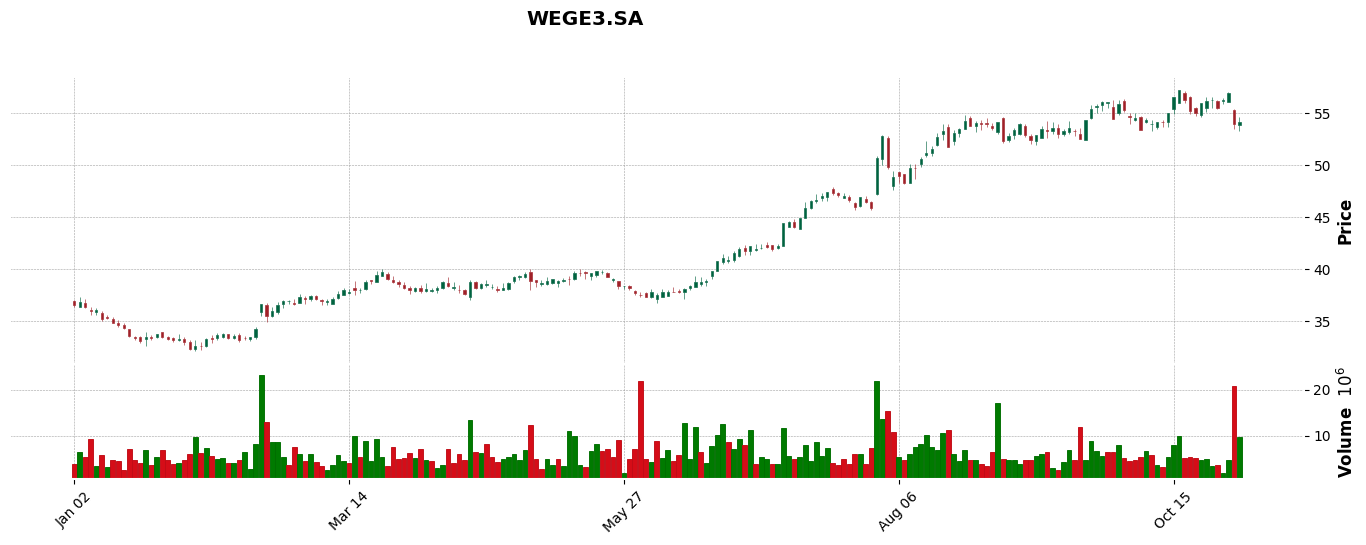

In [46]:
def ohlc_plot(ticker, inicio='1900-01-01', fim=None, period='max'):
    df: pd.DataFrame = yf.download(ticker, inicio, fim, period=period, progress=False)
    df.columns = df.columns.droplevel(1)
    return mpf.plot(df, type='candle', style='charles', volume=True, figratio=(25,8), title=ticker)

ohlc_plot('WEGE3.SA', '2024-01-01')

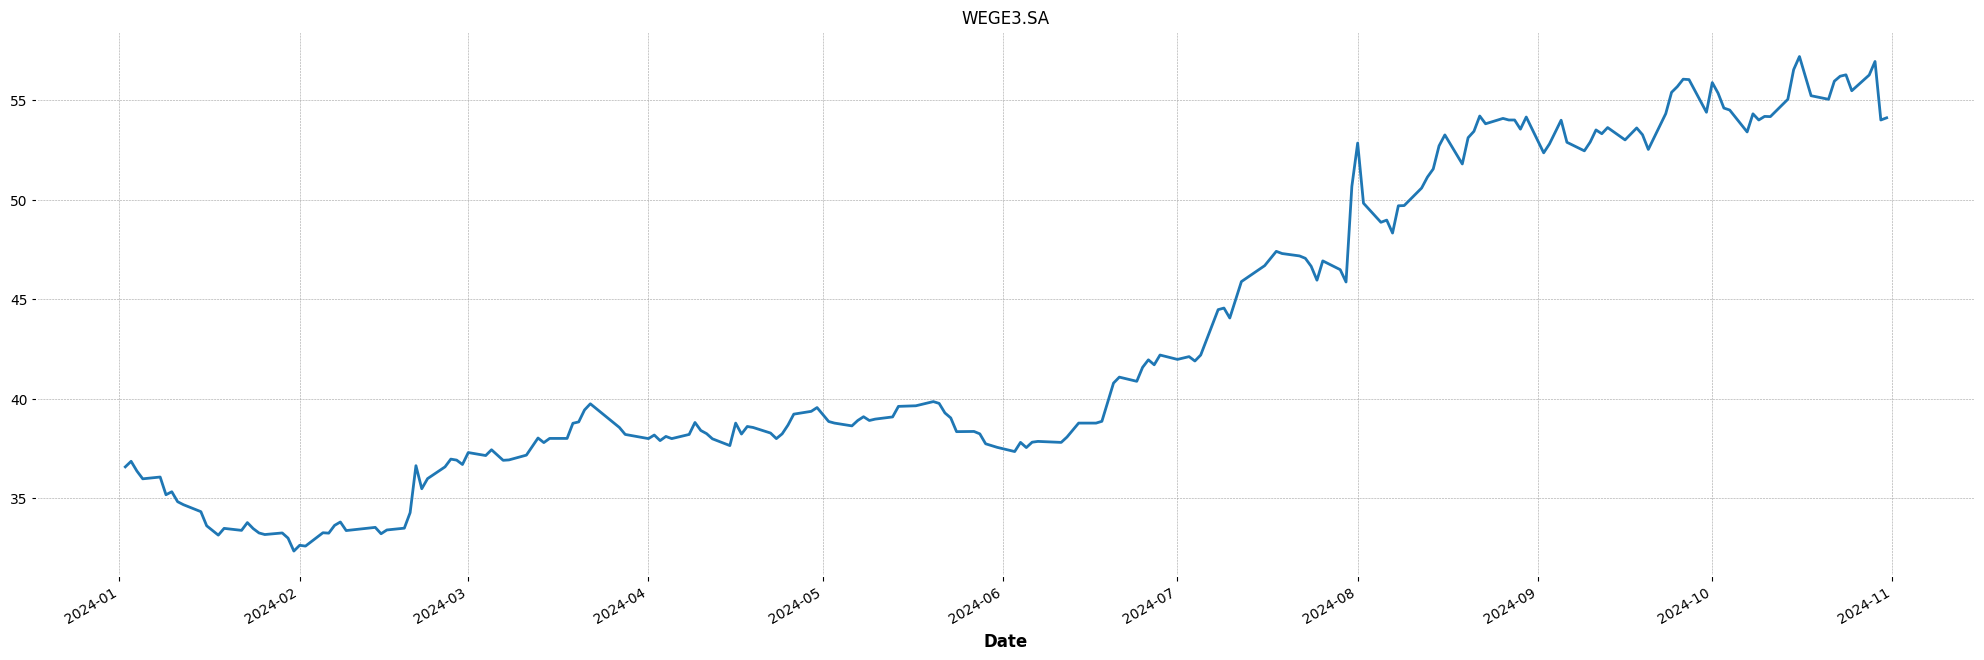

In [47]:
def plot_fechamento(ticker, inicio='1900-01-01', fim=None, period='max'):
    df: pd.DataFrame = yf.download(ticker, inicio, fim, period=period, progress=False)
    df.columns = df.columns.droplevel(1)
    return df['Close'].plot(figsize=(25,8), title=ticker)

plot_fechamento('WEGE3.SA', '2024-01-01');

# Criar dataset e dataloader para utilização no treinamento

In [48]:
from torch.utils.data import Dataset, DataLoader

In [66]:
class StockDataset(Dataset):
    def __init__(self, ticker, inicio='1900-01-01', fim=None, periodo='max', lookback=21):
        df = self._baixar_dados_acao(ticker, inicio, fim, periodo)

        self.lookback = lookback
        self.df = df
        self.close = df['Close'].to_numpy()

    def _baixar_dados_acao(self, ticker, inicio='1900-01-01', fim=None, periodo='max'):
        df = yf.download(ticker, inicio, fim, period=periodo, progress=False)
        df.columns = df.columns.droplevel(1)
        return df

    def __len__(self):
        return len(self.df) - self.lookback

    def __getitem__(self, idx):
        return self.close[idx : idx+self.lookback], self.close[idx+self.lookback]

In [67]:
ds = StockDataset('WEGE3.SA', '2024-01-01')

In [84]:
ds[0]

(array([36.56999969, 36.84999847, 36.36000061, 35.97000122, 36.06000137,
        35.16999817, 35.31999969, 34.81999969, 34.66999817, 34.31999969,
        33.61000061, 33.40000153, 33.13999939, 33.47999954, 33.38000107,
        33.77000046, 33.47000122, 33.25      , 33.16999817, 33.25      ,
        32.99000168]),
 np.float64(32.34000015258789))

In [71]:
for idx, (x, y) in enumerate(DataLoader(ds, batch_size=32, shuffle=False)):
    print(len(x), len(y))
    if idx == 3:
        break

32 32
32 32
32 32
32 32


# Transforma os dados para um formato amigavel para ML

In [82]:
close:np.array = ds.close
((close[1:] / close[:-1] - 1) * 100)[:5]

array([ 0.76565158, -1.32970932, -1.07260556,  0.25020892, -2.4681175 ])

O código anterior transforma cada item em uma procentagem com relação ao item anterior

In [90]:
def transforma_valores(x:np.array, y:np.float64):
    y = y / x[-1] - 1
    x = x[1:] / x[:-1] - 1
    return x, y

x, y = ds[0]
x_trans, y_trans = transforma_valores(x, y)

print(x, y)
print(x_trans, y_trans)

[36.56999969 36.84999847 36.36000061 35.97000122 36.06000137 35.16999817
 35.31999969 34.81999969 34.66999817 34.31999969 33.61000061 33.40000153
 33.13999939 33.47999954 33.38000107 33.77000046 33.47000122 33.25
 33.16999817 33.25       32.99000168] 32.34000015258789
[ 0.00765652 -0.01329709 -0.01072606  0.00250209 -0.02468117  0.00426504
 -0.01415629 -0.00430791 -0.01009514 -0.02068762 -0.00624811 -0.00778449
  0.01025951 -0.00298681  0.01168362 -0.0088836  -0.00657309 -0.00240607
  0.00241187 -0.0078195 ] -0.019702985535256068


In [91]:
def reverter_transformacao(ultimo_x:np.float64, y:np.float64):
    y = (y + 1) * ultimo_x
    return y

reverter_transformacao(x[-1], y_trans) 

np.float64(32.34000015258789)